In [2]:
import glob
from itertools import chain
# import lpips
import matplotlib.pyplot as plt
import numpy as np
from os import path
import pandas as pd
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score
import torch
from torch import nn, optim
from torch import Tensor
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.transforms import Compose
from torchvision.io import read_image
from typing import Tuple, List

In [3]:
img_path = '/kaggle/input/dlmi-lymphs/data/trainset'
train_df_full = pd.read_csv('/kaggle/input/data-split/train_set.csv')
val_df_full = pd.read_csv('/kaggle/input/data-split/val_set.csv')
test_df_full = pd.read_csv('/kaggle/input/data-split/test_set.csv')

#### Train AutoEncoder

In [4]:
class InstanceImageDataset(Dataset):
    """This dataset samples the images of a set, without labels."""

    def __init__(self, img_dir: str, data_df: pd.DataFrame, transform: Compose = None):
        """
        Args:
            img_dir: Path to the images directory.
            transform: Optional, transformations applied to the tensor.
        """
        self.img_dir = img_dir
        self.transform = transform

        for patient_id in data_df['ID']:
            self.img_paths = [glob.glob(path.join(img_dir + '/' + patient_id, '*.jpg'))]
        self.img_paths = list(chain.from_iterable(self.img_paths))

    def __len__(self) -> int:
        return len(self.img_paths)

    def __getitem__(self, idx: int) -> Tensor:
        """
        Args:
            idx: The index of the subject whose data is loaded.
        Returns:
            image: Image tensor.
        """
        img = read_image(self.img_paths[idx])
        if self.transform is not None:
            img = self.transform(img)
        return img

In [5]:
class CNN_Encoder(nn.Module):
    def __init__(self, output_size: int, input_size: Tuple[int, int, int] = (3, 64, 64)):
        super(CNN_Encoder, self).__init__()

        self.input_size = input_size
        self.channel_mult = 16

        #convolutions
        self.conv = nn.Sequential(
            nn.Conv2d(3, self.channel_mult*1, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.channel_mult*1, self.channel_mult*2, 4, 2, 1),
            nn.BatchNorm2d(self.channel_mult*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.channel_mult*2, self.channel_mult*4, 4, 2, 1),
            nn.BatchNorm2d(self.channel_mult*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.channel_mult*4, self.channel_mult*8, 4, 2, 1),
            nn.BatchNorm2d(self.channel_mult*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.channel_mult*8, self.channel_mult*16, 3, 2, 1),
            nn.BatchNorm2d(self.channel_mult*16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(self.channel_mult*16, self.channel_mult*16, 3, 1, 1),
            nn.BatchNorm2d(self.channel_mult*16),
            nn.LeakyReLU(0.2, inplace=True)

        )

        self.flat_fts = self.get_flat_fts(self.conv)

        self.linear = nn.Sequential(
            nn.Linear(self.flat_fts, int(self.flat_fts/2)),
            nn.Linear(int(self.flat_fts/2), output_size),
            nn.BatchNorm1d(output_size),
            nn.LeakyReLU(0.2),
        )

    def get_flat_fts(self, fts) -> int:
        f = fts(Variable(torch.ones(1, 3, 64, 64)))
        return int(np.prod(f.size()[1:]))

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = x.view(-1, self.flat_fts)
        return self.linear(x)

class CNN_Encoder_Resnet(nn.Module):
    def __init__(self, output_size: int, input_size: Tuple[int, int, int] = (3, 64, 64)):
        super(CNN_Encoder_Resnet, self).__init__()
        self.resnet = models.resnet18()
        self.flat_fts = 512
        self.resnet.fc = nn.Sequential(
            nn.Linear(self.flat_fts, int(self.flat_fts/2)),
            nn.Linear(int(self.flat_fts/2), output_size),
            nn.BatchNorm1d(output_size),
            nn.LeakyReLU(0.2),
        )

    def get_flat_fts(self, fts) -> int:
        f = fts(Variable(torch.ones(1, 3, 64, 64)))
        return int(np.prod(f.size()[1:]))

    def forward(self, x: Tensor) -> Tensor:
        x = self.resnet(x)
        return x

class CNN_Decoder(nn.Module):
    def __init__(self, embedding_size: int = 256, input_size: Tuple[int, int, int] = (3, 64, 64)):
        super(CNN_Decoder, self).__init__()
        self.input_height = input_size[1]
        self.input_width = input_size[2]
        self.input_dim = embedding_size
        self.channel_mult = 16
        self.output_channels = input_size[0]
        self.fc_output_dim = 64*64

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, self.fc_output_dim),
            nn.BatchNorm1d(self.fc_output_dim),
            nn.ReLU(True)
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.fc_output_dim, self.channel_mult*8,
                                4, 1, 0, bias=False),  # Adjusted kernel, stride, padding
            nn.BatchNorm2d(self.channel_mult*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.channel_mult*8, self.channel_mult*4,
                                4, 2, 1, bias=False),  # Adjusted kernel, stride, padding
            nn.BatchNorm2d(self.channel_mult*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.channel_mult*4, self.channel_mult*2,
                                4, 2, 1, bias=False),  # Adjusted kernel, stride, padding
            nn.BatchNorm2d(self.channel_mult*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.channel_mult*2, self.channel_mult,
                                4, 2, 1, bias=False),  # Adjusted kernel, stride, padding
            nn.BatchNorm2d(self.channel_mult),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.channel_mult, self.output_channels,
                                4, 2, 1, bias=False),  # Adjusted kernel, stride, padding
            nn.Sigmoid()
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.fc(x)
        x = x.view(-1, self.fc_output_dim, 1, 1)
        x = self.deconv(x)
        return x
    
class Network(nn.Module):
    def __init__(self, embedding_size: int = 256):
        super(Network, self).__init__()
        self.encoder = CNN_Encoder(embedding_size)
        self.decoder = CNN_Decoder(embedding_size)

    def encode(self, x: Tensor) -> Tensor:
        return self.encoder(x)

    def decode(self, z: Tensor) -> Tensor:
        return self.decoder(z)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        z = self.encode(x)
        return z, self.decode(z)


In [6]:
apply_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class AE(object):
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        train_dataset = InstanceImageDataset(img_path, train_df_full, apply_transforms)
        val_dataset = InstanceImageDataset(img_path, val_df_full, apply_transforms)
        self.train_loader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=4)
        self.val_loader = DataLoader(dataset=val_dataset, batch_size=64, num_workers=4)

        self.model = Network()
        self.model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-2)
        # self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=200, gamma=0.8)

    def loss_function(self, recon_x: Tensor, x: Tensor) -> float:
        # loss_f = lpips.LPIPS(net='vgg').to(self.device)
        # loss_lpips = loss_f.forward(recon_x, x, normalize=True).sum()
        loss_mse = 100*F.mse_loss(recon_x, x)
        return loss_mse

    def train(self, epoch: int):
        log_interval = 5
        self.model.train()
        train_loss = 0
        for batch_idx, data in enumerate(self.train_loader):
            data = data.to(self.device)
            self.optimizer.zero_grad()
            latent_space, recon_batch = self.model(data)
            loss = self.loss_function(recon_batch, data)
            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(self.train_loader.dataset),
                    100. * batch_idx / len(self.train_loader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
              epoch, train_loss / len(self.train_loader.dataset)))

    def test(self, epoch: int):
        self.model.eval()
        val_loss = 0
        with torch.no_grad():
            for i, data in enumerate(self.val_loader):
                data = data.to(self.device)
                latent_space, recon_batch = self.model(data)
                val_loss += self.loss_function(recon_batch, data).item()

        val_loss /= len(self.val_loader.dataset)
        print('====> Val set loss: {:.4f}'.format(val_loss))

In [11]:
autoenc = AE()

for epoch in range(1, 250):
    autoenc.train(epoch)
    autoenc.test(epoch)

Train Epoch: 1 [0/66 (0%)]	Loss: 0.164012
====> Epoch: 1 Average loss: 0.2752
====> Val set loss: 0.5378
Train Epoch: 2 [0/66 (0%)]	Loss: 0.087343
====> Epoch: 2 Average loss: 0.1377
====> Val set loss: 0.4710
Train Epoch: 3 [0/66 (0%)]	Loss: 0.048639
====> Epoch: 3 Average loss: 0.0864
====> Val set loss: 0.3584
Train Epoch: 4 [0/66 (0%)]	Loss: 0.041903
====> Epoch: 4 Average loss: 0.0772
====> Val set loss: 0.3400
Train Epoch: 5 [0/66 (0%)]	Loss: 0.040561
====> Epoch: 5 Average loss: 0.0741
====> Val set loss: 0.3237
Train Epoch: 6 [0/66 (0%)]	Loss: 0.038919
====> Epoch: 6 Average loss: 0.0717
====> Val set loss: 0.2885
Train Epoch: 7 [0/66 (0%)]	Loss: 0.036925
====> Epoch: 7 Average loss: 0.0642
====> Val set loss: 0.2458
Train Epoch: 8 [0/66 (0%)]	Loss: 0.034021
====> Epoch: 8 Average loss: 0.0599
====> Val set loss: 0.1880
Train Epoch: 9 [0/66 (0%)]	Loss: 0.032061
====> Epoch: 9 Average loss: 0.0557
====> Val set loss: 0.1038
Train Epoch: 10 [0/66 (0%)]	Loss: 0.031439
====> Epoch:

In [15]:
# torch.save(autoenc, 'CNN_mse_512.pth')

autoenc = torch.load('/kaggle/working/CNN_mse_256.pth')

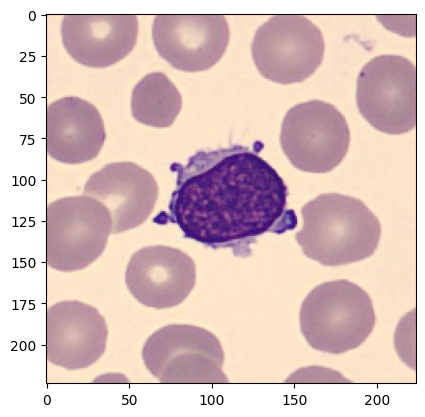

In [17]:
img = read_image('/kaggle/input/dlmi-lymphs/data/trainset/P10/000000.jpg')
plt.imshow(np.moveaxis(np.array(img),0,2))
img = apply_transforms(img)

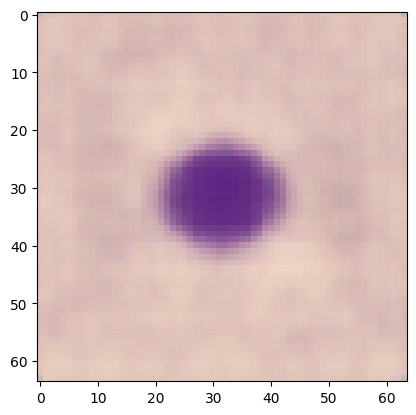

In [18]:
img_batch = img.to('cuda').unsqueeze(0)
latent, out = autoenc.model(img_batch)

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/(0.229*2), 1/(0.224*2), 1/(2*0.225) ]),
                                 transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

# out = invTrans(out)
out_np = out.squeeze(0).detach().cpu()
plt.imshow(np.moveaxis(np.array(out_np),0,2))
plt.imsave('P111_CNN_mse_512.png', np.moveaxis(np.array(out_np),0,2))

#### Aggregation & Classification with SVM

In [7]:
class BagDataset(Dataset):
    """This dataset returns the images and clinical data for each patient."""

    def __init__(self, img_dir: str, data_df: pd.DataFrame, transform: Compose = None) -> None:
        """
        Args:
            img_dir: Path to the images directory.
            data_df: List of subjects used.
            transform: Optional, transformations applied to the tensor.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.data_df = data_df

    def __len__(self) -> int:
        return len(self.data_df)

    def __getitem__(self, idx: int) -> dict[List[Tensor], int, str, float, float, float]:
        """
        Args:
            idx: The index of the subject whose data is loaded.
        Returns:
            sample: corresponding data described by the following keys:
                images: List with image tensors.
                label: The diagnosis code.
                id: ID of the participant.
                gender: 0.0 for male, '1' for female.
                age: Age value.
                lymph_count: Lymph count value.
        """

        label = self.data_df.loc[idx, 'LABEL']
        age = self.data_df.loc[idx, 'AGE']
        gender = self.data_df.loc[idx, 'GENDER']
        lymph_count = self.data_df.loc[idx, 'LYMPH_COUNT']

        id = self.data_df.loc[idx, 'ID']
        folder_name = path.join(self.img_dir, id)
        images = []
        for filename in Path(folder_name).glob('*'):
            image = read_image(str(filename))

            if self.transform:
                image = self.transform(image)
            images.append(image)

        sample = {'images': images, 'label': label,
                  'id': id, 'gender': gender, 'age': age,
                  'lymph_count': lymph_count}
        
        return sample

In [8]:
test_transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(64),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [10]:
autoenc = torch.load('/kaggle/working/CNN_mse_256.pth')

bag_dataloader = DataLoader(BagDataset(img_path, train_df_full, transform=test_transforms), batch_size=1)

train_per_patient_features_mse = []

for i, patient_data in enumerate(bag_dataloader):
    patient_features = []
    patient_imgs = patient_data['images']
    for img in patient_imgs:
        with torch.no_grad():
            img_features, _ = autoenc.model(img.to('cuda'))
            img_features = img_features.squeeze(0).cpu().numpy()
        patient_features.append(img_features)
    train_per_patient_features_mse.append(patient_features)


In [11]:
bag_dataloader = DataLoader(BagDataset(img_path, val_df_full, transform=test_transforms), batch_size=1)

val_per_patient_features_mse = []

for i, patient_data in enumerate(bag_dataloader):
    patient_features = []
    patient_imgs = patient_data['images']
    for img in patient_imgs:
        with torch.no_grad():
            img_features, _ = autoenc.model(img.to('cuda'))
            img_features = img_features.squeeze(0).cpu().numpy()
        patient_features.append(img_features)
    val_per_patient_features_mse.append(patient_features)

In [12]:
autoenc = torch.load('/kaggle/working/CNN_lpips_256.pth')

bag_dataloader = DataLoader(BagDataset(img_path, train_df_full, transform=test_transforms), batch_size=1)

train_per_patient_features_lpips = []

for i, patient_data in enumerate(bag_dataloader):
    patient_features = []
    patient_imgs = patient_data['images']
    for img in patient_imgs:
        with torch.no_grad():
            img_features, _ = autoenc.model(img.to('cuda'))
            img_features = img_features.squeeze(0).cpu().numpy()
        patient_features.append(img_features)
    train_per_patient_features_lpips.append(patient_features)


In [13]:
bag_dataloader = DataLoader(BagDataset(img_path, val_df_full, transform=test_transforms), batch_size=1)

val_per_patient_features_lpips = []

for i, patient_data in enumerate(bag_dataloader):
    patient_features = []
    patient_imgs = patient_data['images']
    for img in patient_imgs:
        with torch.no_grad():
            img_features, _ = autoenc.model(img.to('cuda'))
            img_features = img_features.squeeze(0).cpu().numpy()
        patient_features.append(img_features)
    val_per_patient_features_lpips.append(patient_features)

In [14]:
def from_full_df_to_set(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train_df = train_df_full.drop('index', axis=1)
    train_df = train_df.drop('ID', axis=1)
    val_df = val_df_full.drop('index', axis=1)
    val_df = val_df.drop('ID', axis=1)
    test_df = test_df_full.drop('index', axis=1)
    test_df = test_df.drop('ID', axis=1)

    print(f"Training data shape: {train_df.shape}")

    y_train = train_df['LABEL']
    train_df.drop('LABEL', axis=1, inplace=True)
    X_train = train_df

    y_val = val_df['LABEL']
    val_df.drop('LABEL', axis=1, inplace=True)
    X_val = val_df

    test_df.drop('LABEL', axis=1, inplace=True)
    X_test = test_df

    return X_train, y_train, X_val, y_val, X_test

X_train, y_train, X_val, y_val, X_test = from_full_df_to_set(train_df_full, val_df_full, test_df_full)

Training data shape: (130, 4)


In [15]:
y_train_0 = y_train.copy()
y_train[y_train == 0] = -1

In [16]:
!python3 -m pip install -e git+https://github.com/garydoranjr/misvm.git#egg=misvm

Obtaining misvm from git+https://github.com/garydoranjr/misvm.git#egg=misvm
  Updating ./src/misvm clone
  Running command git fetch -q --tags
  Running command git reset --hard -q b2118fe04d98c00436bdf8a0e4bbfb6082c5751c
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 82.0 MB/s eta 0:00:00:00:0100:01
  Running setup.py develop for misvm


In [17]:
import sys
sys.path
sys.path.append('/kaggle/working/src/misvm')

In [18]:
total = 0
for i in range(len(train_per_patient_features_mse)):
    total += len(train_per_patient_features_mse[i])
print(total)

10839


In [19]:
import misvm

In [ ]:
clf_1 = misvm.NSK(kernel='quadratic', C=45)
clf_1.fit(train_per_patient_features_mse, y_train)

In [61]:
preds_train_1 = clf_1.predict(train_per_patient_features_mse)
preds_train_1 = np.sign(np.array(preds_train_1))
preds_train_1[preds_train_1==-1] = 0
print('Train: ', balanced_accuracy_score(preds_train_1, y_train_0))

preds_val_1 = clf_1.predict(val_per_patient_features_mse)
preds_val_1 = np.sign(np.array(preds_val_1))
preds_val_1[preds_val_1==-1] = 0
print('Val: ', balanced_accuracy_score(preds_val_1, y_val))

Train:  0.9277777777777778
Val:  0.7847826086956522


In [58]:
clf_2 = misvm.NSK(kernel='linear', C=0.5)
clf_2.fit(train_per_patient_features_mse, y_train)

Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -4.9641e+00 -2.7165e+00  5e+02  2e+01  6e-11
 1: -2.2800e+00 -1.3893e+00  4e+01  2e+00  7e-11
 2: -5.1149e-01 -8.4952e-01  4e+00  2e-01  2e-11
 3: -2.6870e-01 -6.4605e-01  1e+00  3e-02  6e-12
 4: -2.0804e-01 -4.6166e-01  5e-01  1e-02  2e-12
 5: -1.9293e-01 -2.9304e-01  1e-01  3e-03  1e-12
 6: -1.8833e-01 -2.2708e-01  5e-02  8e-04  1e-12
 7: -1.9220e-01 -1.9701e-01  6e-03  6e-05  9e-13
 8: -1.9336e-01 -1.9376e-01  5e-04  4e-06  1e-12
 9: -1.9348e-01 -1.9350e-01  3e-05  2e-07  1e-12
10: -1.9349e-01 -1.9349e-01  8e-07  3e-09  1e-12
11: -1.9349e-01 -1.9349e-01  3e-08  4e-11  1e-12
Optimal solution found.


In [59]:
preds_train_2 = clf_2.predict(train_per_patient_features_mse)
preds_train_2 = np.sign(np.array(preds_train_2))
preds_train_2[preds_train_2==-1] = 0
print('Train: ', balanced_accuracy_score(preds_train_2, y_train_0))

preds_val_2 = clf_2.predict(val_per_patient_features_mse)
preds_val_2 = np.sign(np.array(preds_val_2))
preds_val_2[preds_val_2==-1] = 0
print('Val: ', balanced_accuracy_score(preds_val_2, y_val))

Train:  0.8113553113553114
Val:  0.8211538461538461


In [83]:
clf_3 = misvm.NSK(kernel='linear', C=0.01)
clf_3.fit(train_per_patient_features_lpips, y_train)

Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -3.8503e-01 -3.5538e-01  3e+02  2e+01  2e-10
 1: -3.7492e-01 -2.9180e-01  1e+01  8e-01  9e-11
 2: -1.2983e-01 -5.6765e-02  2e+00  1e-01  1e-10
 3: -2.5291e-02 -1.9342e-02  2e-01  1e-02  4e-11
 4: -7.7068e-03 -1.4985e-02  4e-02  1e-03  7e-12
 5: -4.8414e-03 -1.1052e-02  1e-02  3e-04  2e-12
 6: -4.4430e-03 -8.0532e-03  6e-03  1e-04  9e-13
 7: -4.5231e-03 -5.6417e-03  2e-03  3e-05  5e-13
 8: -4.5916e-03 -4.9888e-03  5e-04  7e-06  4e-13
 9: -4.6350e-03 -4.7405e-03  1e-04  1e-06  4e-13
10: -4.6609e-03 -4.6724e-03  1e-05  1e-07  4e-13
11: -4.6640e-03 -4.6644e-03  5e-07  3e-09  4e-13
12: -4.6641e-03 -4.6642e-03  1e-08  7e-11  5e-13
Optimal solution found.


In [84]:
preds_train_3 = clf_3.predict(train_per_patient_features_lpips)
preds_train_3 = np.sign(np.array(preds_train_3))
preds_train_3[preds_train_3==-1] = 0
print('Train: ', balanced_accuracy_score(preds_train_3, y_train_0))

preds_val_3 = clf_3.predict(val_per_patient_features_lpips)
preds_val_3 = np.sign(np.array(preds_val_3))
preds_val_3[preds_val_3==-1] = 0
print('Val: ', balanced_accuracy_score(preds_val_3, y_val))

Train:  0.7652777777777777
Val:  0.75


In [99]:
clf_4 = misvm.MISVM(kernel='linear', C=15, max_iters=15)
clf_4.fit(train_per_patient_features_mse, y_train)

Non-random start...

Iteration 1...
Training SVM...
     pcost       dcost       gap    pres   dres
 0: -8.3223e+01 -1.9318e+00  7e+03  1e+02  3e-13
 1: -2.0471e+00 -1.8657e+00  1e+02  2e+00  3e-13
 2: -6.7323e-01 -1.6815e+00  8e+00  9e-02  2e-14
 3: -5.5340e-01 -1.0586e+00  1e+00  1e-02  3e-14
 4: -5.3575e-01 -7.8485e-01  3e-01  2e-03  2e-14
 5: -5.3681e-01 -5.9983e-01  7e-02  3e-04  7e-15
 6: -5.3757e-01 -5.5620e-01  2e-02  2e-16  2e-14
 7: -5.3800e-01 -5.4085e-01  3e-03  4e-16  3e-14
 8: -5.3809e-01 -5.3864e-01  6e-04  2e-16  3e-13
 9: -5.3811e-01 -5.3823e-01  1e-04  2e-16  2e-12
10: -5.3811e-01 -5.3815e-01  4e-05  2e-16  1e-11
11: -5.3812e-01 -5.3812e-01  8e-06  3e-17  3e-11
12: -5.3812e-01 -5.3812e-01  2e-06  1e-16  2e-10
13: -5.3812e-01 -5.3812e-01  9e-07  8e-17  4e-10
14: -5.3812e-01 -5.3812e-01  4e-07  8e-17  2e-09
Optimal solution found.
Recomputing classes...
Selector differences: 2230
Updating QP...

Iteration 2...
Training SVM...
     pcost       dcost       gap    pres   d

In [100]:
preds_train_4 = clf_4.predict(train_per_patient_features_mse)
preds_train_4 = np.sign(np.array(preds_train_4))
preds_train_4[preds_train_4==-1] = 0
print('Train: ', balanced_accuracy_score(preds_train_4, y_train_0))

preds_val_4 = clf_4.predict(val_per_patient_features_mse)
preds_val_4 = np.sign(np.array(preds_val_4))
preds_val_4[preds_val_4==-1] = 0
print('Val: ', balanced_accuracy_score(preds_val_4, y_val))

Train:  0.7069060016442861
Val:  0.717391304347826


In [105]:
clf_5 = misvm.MISVM(kernel='quadratic', C=45, max_iters=15)
clf_5.fit(train_per_patient_features_mse, y_train)

Non-random start...

Iteration 1...
Training SVM...
     pcost       dcost       gap    pres   dres
 0: -3.5507e+00 -4.6150e+00  5e+03  7e+01  6e-12
 1: -1.0196e+00 -4.0888e+00  2e+02  3e+00  4e-12
 2: -4.8189e-01 -2.9959e+00  4e+01  5e-01  2e-12
 3: -3.0830e-01 -1.6633e+00  2e+01  2e-01  8e-13
 4: -2.1164e-01 -9.3242e-01  7e+00  8e-02  4e-13
 5: -1.4580e-01 -5.8019e-01  3e+00  3e-02  2e-13
 6: -1.1210e-01 -3.6438e-01  1e+00  9e-03  1e-13
 7: -9.4484e-02 -2.9484e-01  6e-01  4e-03  9e-14
 8: -9.4381e-02 -2.2549e-01  3e-01  2e-03  7e-14
 9: -9.2936e-02 -1.9694e-01  2e-01  1e-03  6e-14
10: -9.0219e-02 -1.8204e-01  2e-01  6e-04  5e-14
11: -9.4768e-02 -1.5994e-01  1e-01  3e-04  5e-14
12: -9.7144e-02 -1.5083e-01  7e-02  1e-04  5e-14
13: -1.0316e-01 -1.3621e-01  4e-02  4e-05  5e-14
14: -1.0430e-01 -1.3374e-01  3e-02  3e-05  5e-14
15: -1.0960e-01 -1.2623e-01  2e-02  2e-05  5e-14
16: -1.1334e-01 -1.2255e-01  9e-03  5e-17  7e-14
17: -1.1610e-01 -1.2102e-01  5e-03  7e-17  7e-14
18: -1.1790e-01 -1

In [106]:
preds_train_5 = clf_5.predict(train_per_patient_features_mse)
preds_train_5 = np.sign(np.array(preds_train_5))
preds_train_5[preds_train_5==-1] = 0
print('Train: ', balanced_accuracy_score(preds_train_5, y_train_0))

preds_val_5 = clf_5.predict(val_per_patient_features_mse)
preds_val_5 = np.sign(np.array(preds_val_5))
preds_val_5[preds_val_5==-1] = 0
print('Val: ', balanced_accuracy_score(preds_val_5, y_val))

Train:  0.937367864693446
Val:  0.8516483516483516


In [117]:
clf_6 = misvm.MISVM(kernel='linear', C=15)
clf_6.fit(train_per_patient_features_lpips, y_train)

Non-random start...

Iteration 1...
Training SVM...
     pcost       dcost       gap    pres   dres
 0: -8.3394e+01 -1.8647e+00  7e+03  1e+02  7e-12
 1: -1.6734e+00 -1.8570e+00  9e+01  1e+00  5e-12
 2: -6.5597e-01 -1.6358e+00  7e+00  8e-02  3e-13
 3: -5.4475e-01 -9.8414e-01  8e-01  7e-03  7e-14
 4: -5.3645e-01 -6.9191e-01  2e-01  7e-04  4e-14
 5: -5.3733e-01 -5.7898e-01  4e-02  2e-04  4e-14
 6: -5.3779e-01 -5.4413e-01  6e-03  2e-06  5e-14
 7: -5.3804e-01 -5.3947e-01  1e-03  1e-07  2e-13
 8: -5.3810e-01 -5.3840e-01  3e-04  7e-09  8e-13
 9: -5.3811e-01 -5.3817e-01  6e-05  4e-11  4e-12
10: -5.3812e-01 -5.3813e-01  2e-05  5e-12  1e-11
11: -5.3812e-01 -5.3813e-01  1e-05  4e-12  3e-11
12: -5.3812e-01 -5.3813e-01  1e-05  4e-12  3e-11
13: -5.3812e-01 -5.3813e-01  1e-05  4e-12  3e-11
14: -5.3812e-01 -5.3813e-01  1e-05  3e-12  3e-11
15: -5.3812e-01 -5.3813e-01  1e-05  3e-12  5e-11
16: -5.3812e-01 -5.3813e-01  1e-05  3e-12  5e-11
17: -5.3812e-01 -5.3813e-01  9e-06  8e-13  1e-10
18: -5.3812e-01 -5

Selector differences: 2230
Updating QP...

Iteration 2...
Training SVM...
     pcost       dcost       gap    pres   dres
 0: -6.2966e+01 -2.2147e+00  7e+03  9e+01  5e-12
 1: -2.0388e+00 -2.0838e+00  1e+02  2e+00  5e-12
 2: -6.4818e-01 -1.7216e+00  9e+00  1e-01  3e-13
 3: -5.3254e-01 -1.0266e+00  2e+00  2e-02  7e-14
 4: -5.1145e-01 -7.7756e-01  5e-01  3e-03  4e-14
 5: -5.1502e-01 -6.4056e-01  1e-01  6e-04  4e-14
 6: -5.2336e-01 -5.7232e-01  5e-02  1e-04  4e-14
 7: -5.2869e-01 -5.4973e-01  2e-02  2e-05  8e-14
 8: -5.3141e-01 -5.4194e-01  1e-02  4e-06  2e-13
 9: -5.3320e-01 -5.3825e-01  5e-03  1e-06  4e-13
10: -5.3418e-01 -5.3684e-01  3e-03  1e-07  1e-12
11: -5.3471e-01 -5.3611e-01  1e-03  5e-08  9e-13
12: -5.3515e-01 -5.3571e-01  6e-04  1e-08  1e-12
13: -5.3531e-01 -5.3558e-01  3e-04  1e-11  3e-12
14: -5.3547e-01 -5.3553e-01  6e-05  2e-12  3e-12
15: -5.3551e-01 -5.3552e-01  8e-06  2e-16  5e-12
16: -5.3552e-01 -5.3552e-01  3e-07  8e-17  1e-11
Optimal solution found.
Recomputing classes..

In [118]:
preds_train_6 = clf_6.predict(train_per_patient_features_lpips)
preds_train_6 = np.sign(np.array(preds_train_6))
preds_train_6[preds_train_6==-1] = 0
print('Train: ', balanced_accuracy_score(preds_train_6, y_train_0))

preds_val_6 = clf_6.predict(val_per_patient_features_lpips)
preds_val_6 = np.sign(np.array(preds_val_6))
preds_val_6[preds_val_6==-1] = 0
print('Val: ', balanced_accuracy_score(preds_val_6, y_val))

Train:  0.81875
Val:  0.7166666666666667


In [119]:
clf_7 = misvm.sMIL(kernel='linear', C=10)
clf_7.fit(train_per_patient_features_mse, y_train)

Setup QP...
Solving QP...
     pcost       dcost       gap    pres   dres
 0: -1.8450e-02 -2.1375e+01  5e+03  6e+01  4e-12
 1: -4.6189e-03 -1.9454e+01  1e+02  1e+00  1e-12
 2:  6.8429e-03 -1.0807e+01  3e+01  3e-01  2e-12
 3:  7.5824e-03 -5.8728e+00  1e+01  9e-02  1e-12
 4:  8.1556e-03 -2.9546e+00  5e+00  3e-02  7e-13
 5:  4.7045e-03 -1.4022e+00  2e+00  1e-02  3e-13
 6:  2.3978e-03 -4.7419e-01  7e-01  3e-03  9e-14
 7:  1.3703e-03 -3.2476e-01  5e-01  2e-03  5e-14
 8:  8.3349e-04 -1.8256e-01  3e-01  9e-04  3e-14
 9:  8.5914e-04 -1.2128e-01  2e-01  4e-04  4e-14
10:  9.3116e-04 -6.0441e-02  9e-02  2e-04  2e-14
11:  1.0677e-03 -2.9928e-02  4e-02  7e-05  3e-14
12:  1.5557e-03 -1.8342e-02  3e-02  2e-05  4e-14
13:  5.4322e-04 -7.6158e-04  1e-03  3e-07  2e-13
14:  7.4860e-05 -9.7868e-05  2e-04  2e-16  9e-15
15:  8.4787e-06 -1.6353e-05  2e-05  2e-16  5e-15
16:  6.6467e-07 -4.5880e-06  5e-06  2e-16  2e-15
17: -6.6715e-07 -2.1783e-06  2e-06  2e-16  9e-16
18: -7.4366e-07 -1.7357e-06  1e-06  2e-16  7

In [120]:
preds_train_7 = clf_7.predict(train_per_patient_features_mse)
preds_train_7 = np.sign(np.array(preds_train_7))
preds_train_7[preds_train_7==-1] = 0
print('Train: ', balanced_accuracy_score(preds_train_7, y_train_0))

preds_val_7 = clf_7.predict(val_per_patient_features_mse)
preds_val_7 = np.sign(np.array(preds_val_7))
preds_val_7[preds_val_7==-1] = 0
print('Val: ', balanced_accuracy_score(preds_val_7, y_val))

Train:  0.6501225490196079
Val:  0.8511904761904762


In [122]:
from joblib import dump, load
dump(clf_1, 'clf_1.joblib') 
dump(clf_2, 'clf_2.joblib') 
dump(clf_3, 'clf_3.joblib') 
dump(clf_4, 'clf_4.joblib') 
dump(clf_5, 'clf_5.joblib') 
dump(clf_6, 'clf_6.joblib') 
dump(clf_7, 'clf_7.joblib') 

['clf_7.joblib']

In [121]:
preds = (preds_val_1 + preds_val_2 + preds_val_3 + 
         preds_val_4 + preds_val_5 + preds_val_6 + 
         preds_val_7) / 7
preds = np.where(preds > 0.5, 1, 0)
print(balanced_accuracy_score(preds, y_val))

0.8211538461538461


##### Test

In [20]:
img_path = '/kaggle/input/dlmi-lymphs/data/testset'
autoenc = torch.load('/kaggle/working/CNN_mse_256.pth')

bag_dataloader = DataLoader(BagDataset(img_path, test_df_full, transform=test_transforms), batch_size=1)

test_per_patient_features_mse = []

for i, patient_data in enumerate(bag_dataloader):
    patient_features = []
    patient_imgs = patient_data['images']
    for img in patient_imgs:
        with torch.no_grad():
            img_features, _ = autoenc.model(img.to('cuda'))
            img_features = img_features.squeeze(0).cpu().numpy()
        patient_features.append(img_features)
    test_per_patient_features_mse.append(patient_features)

In [21]:
autoenc = torch.load('/kaggle/working/CNN_lpips_256.pth')

bag_dataloader = DataLoader(BagDataset(img_path, test_df_full, transform=test_transforms), batch_size=1)

test_per_patient_features_lpips = []

for i, patient_data in enumerate(bag_dataloader):
    patient_features = []
    patient_imgs = patient_data['images']
    for img in patient_imgs:
        with torch.no_grad():
            img_features, _ = autoenc.model(img.to('cuda'))
            img_features = img_features.squeeze(0).cpu().numpy()
        patient_features.append(img_features)
    test_per_patient_features_lpips.append(patient_features)

In [36]:
from joblib import dump, load

class FinalClassifier():
    def __init__(self) -> None:
        self.clf_1 = load('/kaggle/working/clf_1.joblib')
        self.clf_2 = load('/kaggle/working/clf_2.joblib')
        self.clf_3 = load('/kaggle/working/clf_3.joblib')
        self.clf_4 = load('/kaggle/working/clf_4.joblib')
        self.clf_5 = load('/kaggle/working/clf_5.joblib')
        self.clf_6 = load('/kaggle/working/clf_6.joblib')
        self.clf_7 = load('/kaggle/working/clf_7.joblib')
        
    def predict(self, features_mse: np.ndarray, features_lpips: np.ndarray) -> np.ndarray:
        preds_1 = self.clf_1.predict(features_mse)
        preds_1 = np.sign(np.array(preds_1))
        preds_1[preds_1==-1] = 0

        preds_2 = self.clf_2.predict(features_mse)
        preds_2 = np.sign(np.array(preds_2))
        preds_2[preds_2==-1] = 0
        
        preds_3 = self.clf_3.predict(features_lpips)
        preds_3 = np.sign(np.array(preds_3))
        preds_3[preds_3==-1] = 0
        
        preds_4 = self.clf_4.predict(features_mse)
        preds_4 = np.sign(np.array(preds_4))
        preds_4[preds_4==-1] = 0
        
        preds_5 = self.clf_5.predict(features_mse)
        preds_5 = np.sign(np.array(preds_5))
        preds_5[preds_5==-1] = 0
        
        preds_6 = self.clf_6.predict(features_lpips)
        preds_6 = np.sign(np.array(preds_6))
        preds_6[preds_6==-1] = 0
        
        preds_7 = self.clf_7.predict(features_mse)
        preds_7 = np.sign(np.array(preds_7))
        preds_7[preds_7==-1] = 0
        
        preds = (preds_1 + preds_2 + preds_3 + preds_4 + 
                 preds_5 + preds_6 + preds_7) / 7
        preds = np.where(preds > 0.5, 1, 0)
        
        return preds

In [37]:
classifier = FinalClassifier()

preds_train = classifier.predict(train_per_patient_features_mse, train_per_patient_features_lpips)
print('Train: ', balanced_accuracy_score(preds_train, y_train_0))

preds_val = classifier.predict(val_per_patient_features_mse, val_per_patient_features_lpips)
print('Val: ', balanced_accuracy_score(preds_val, y_val))

Train:  0.8843167701863355
Val:  0.8211538461538461


In [130]:
preds_test = classifier.predict(test_per_patient_features_mse, test_per_patient_features_lpips)
print(preds_test)

[1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0
 0 0 0 1 0]


In [71]:
data = {'ID': test_df_full['ID'], 'Predicted': preds_test_5}
output = pd.DataFrame(data=data)

output.to_csv('/kaggle/working/visual_baseline_sub2.csv', index=False)

#### Aggregation via Statistical Description

In [22]:
! pip install mil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 4.8 MB/s eta 0:00:0000:0100:01m


In [23]:
from mil.bag_representation import MILESMapping, DiscriminativeMapping, ArithmeticMeanBagRepresentation, \
                                   MedianBagRepresentation, GeometricMeanBagRepresentation, MinBagRepresentation, \
                                   MaxBagRepresentation, MeanMinMaxBagRepresentation

In [24]:
disc = DiscriminativeMapping()
disc.fit(train_per_patient_features_mse, y=y_train)
disc_train =  disc.transform(train_per_patient_features_mse)
disc_val = disc.transform(val_per_patient_features_mse)
disc_test = disc.transform(test_per_patient_features_mse)

In [25]:
arithmetic_mean_rep = ArithmeticMeanBagRepresentation()
arithmetic_mean_rep_train = arithmetic_mean_rep.transform(train_per_patient_features_mse)
arithmetic_mean_rep_val = arithmetic_mean_rep.transform(val_per_patient_features_mse)
arithmetic_mean_rep_test = arithmetic_mean_rep.transform(test_per_patient_features_mse)

In [26]:
min_max = MeanMinMaxBagRepresentation()
min_max.fit(train_per_patient_features_mse, y_train)
min_max_train = min_max.transform(train_per_patient_features_mse)
min_max_val = min_max.transform(val_per_patient_features_mse)
min_max_test = min_max.transform(test_per_patient_features_mse)

In [32]:
X_train, y_train, X_val, y_val, X_test = from_full_df_to_set(train_df_full, val_df_full, test_df_full)
X_train_full = np.concatenate([X_train, arithmetic_mean_rep_train, min_max_train], axis=1)
print(X_train_full.shape)

X_val_full = np.concatenate([X_val, arithmetic_mean_rep_val, min_max_val], axis=1)
print(X_val_full.shape)

X_test_full = np.concatenate([X_test, arithmetic_mean_rep_test, min_max_test], axis=1)
print(X_test_full.shape)

Training data shape: (130, 4)
(130, 515)
(33, 515)
(42, 515)


In [33]:
from sklearn.ensemble import RandomForestClassifier

# instantiate & fit
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(X_train_full, y_train)
preds_train = rf.predict(X_train_full)
preds_val = rf.predict(X_val_full)
print("Balanced Accuracy on train_set: " + str(balanced_accuracy_score(preds_train, y_train)))
print("Balanced Accuracy on val_set: " + str(balanced_accuracy_score(preds_val, y_val)))

Balanced Accuracy on train_set: 1.0
Balanced Accuracy on val_set: 0.7


In [146]:
preds = rf.predict(X_test_full)

data = {'ID': test_df_full['ID'], 'Predicted': preds}
output = pd.DataFrame(data=data)

output.to_csv('/kaggle/working/rf_combined_sub.csv', index=False)

#### Aggregating SVMs and RF

In [38]:
train_svms = np.zeros((130,7))
train_svms[:,0] = classifier.clf_1.predict(train_per_patient_features_mse)
train_svms[:,1] = classifier.clf_2.predict(train_per_patient_features_mse)
train_svms[:,2] = classifier.clf_3.predict(train_per_patient_features_lpips)
train_svms[:,3] = classifier.clf_4.predict(train_per_patient_features_mse)
train_svms[:,4] = classifier.clf_5.predict(train_per_patient_features_mse)
train_svms[:,5] = classifier.clf_6.predict(train_per_patient_features_lpips)
train_svms[:,6] = classifier.clf_7.predict(train_per_patient_features_mse)

X_train, y_train, X_val, y_val, X_test = from_full_df_to_set(train_df_full, val_df_full, test_df_full)
X_train_full = np.concatenate([X_train, train_svms], axis=1)
print(X_train_full.shape)

val_svms = np.zeros((33,7))
val_svms[:,0] = classifier.clf_1.predict(val_per_patient_features_mse)
val_svms[:,1] = classifier.clf_2.predict(val_per_patient_features_mse)
val_svms[:,2] = classifier.clf_3.predict(val_per_patient_features_lpips)
val_svms[:,3] = classifier.clf_4.predict(val_per_patient_features_mse)
val_svms[:,4] = classifier.clf_5.predict(val_per_patient_features_mse)
val_svms[:,5] = classifier.clf_6.predict(val_per_patient_features_lpips)
val_svms[:,6] = classifier.clf_7.predict(val_per_patient_features_mse)

X_val_full = np.concatenate([X_val, val_svms], axis=1)
print(X_val_full.shape)

test_svms = np.zeros((42,7))
test_svms[:,0] = classifier.clf_1.predict(test_per_patient_features_mse)
test_svms[:,1] = classifier.clf_2.predict(test_per_patient_features_mse)
test_svms[:,2] = classifier.clf_3.predict(test_per_patient_features_lpips)
test_svms[:,3] = classifier.clf_4.predict(test_per_patient_features_mse)
test_svms[:,4] = classifier.clf_5.predict(test_per_patient_features_mse)
test_svms[:,5] = classifier.clf_6.predict(test_per_patient_features_lpips)
test_svms[:,6] = classifier.clf_7.predict(test_per_patient_features_mse)

X_test_full = np.concatenate([X_test, test_svms], axis=1)
print(X_test_full.shape)

Training data shape: (130, 4)
(130, 10)
(33, 10)
(42, 10)


In [41]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(801,), random_state=42, max_iter=1000, alpha=100)
mlp.fit(X_train_full, y_train)
preds_train = mlp.predict(X_train_full)
preds_val = mlp.predict(X_val_full)
preds_test = mlp.predict(X_test_full)

print("Balanced Accuracy on train_set: " + str(balanced_accuracy_score(preds_train, y_train)))
print("Balanced Accuracy on val_set: " + str(balanced_accuracy_score(preds_val, y_val)))

Balanced Accuracy on train_set: 0.9283333333333333
Balanced Accuracy on val_set: 0.8240740740740741
